<a href="https://colab.research.google.com/github/JamesPeralta/NeuroNexus2019/blob/master/ModelTraining/Iteration4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive and download libraries from Github

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Any imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import cv2 
from sklearn.feature_extraction import image
import math
from keras.utils import np_utils
import keras
from sklearn.utils import shuffle
from skimage import io, color, img_as_float

Using TensorFlow backend.


### Retrieve slices and thier ground-truth

In [3]:
# CD into the data
# CD into the data
t1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/HC_T1.nii'
c1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c1HC_T1.nii'

t1_nii = nib.load(t1)
t1_np = np.array(t1_nii.dataobj)
print(t1_np.shape)

c1_nii = nib.load(c1)
c1_np = np.array(c1_nii.dataobj)
print(c1_np.shape)

(256, 256, 344)
(256, 256, 344)


In [0]:
input_slice = 230

In [0]:
t1_np = t1_np[50:230, 30:230, input_slice]
c1_np = c1_np[50:230, 30:230, input_slice]

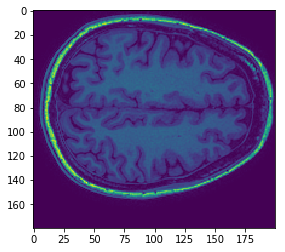

In [6]:
plt.imshow(t1_np)

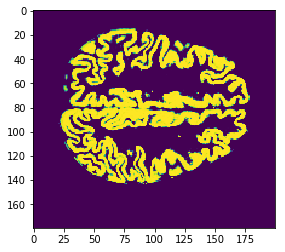

In [7]:
plt.imshow(c1_np)

In [0]:
print(t1_np.shape)
print(c1_np.shape)

### Extract patches

In [0]:
t1_patches = shuffle(image.extract_patches_2d(t1_np, (33, 33)) / 1390, random_state=0)
c1_patches = shuffle(image.extract_patches_2d(c1_np, (33, 33)), random_state=0)

print(t1_patches.shape)
print(c1_patches.shape)

In [0]:
plt.imshow(t1_patches[1])

In [0]:
x = t1_patches.reshape((24864, 33, 33, 1))
print(x.shape)

In [0]:
# Convert c1 patch to thier labels
y = label_patches(c1_patches)
y.shape

In [0]:
print(x.shape)
print(y.shape)

## Stabilize the dataset by dropping alot of the black screens

In [24]:
index_to_drop = zero_index[0:12000]

new_x = np.delete(x, [index_to_drop], axis=0)
new_y = np.delete(y, [index_to_drop], axis=0)

print(new_x.shape)
print(new_y.shape)

(12864, 33, 33, 1)
(12864, 2)


## Creating the Neural Network

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [0]:
# Define the models architecture
def create_model():
    # Build the architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(33, 33, 1), padding="same"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.01), metrics=['acc'])
  
    return model

In [37]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 33, 33, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 262,562
Trainable params: 262,562
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(new_x, new_y, batch_size=128, epochs=5, shuffle=True)

Epoch 1/5
12864/12864 [==============================] - 1s 48us/sample - loss: 0.2317 - acc: 0.9084
Epoch 2/5
12864/12864 [==============================] - 1s 43us/sample - loss: 0.2124 - acc: 0.9174
Epoch 3/5
12864/12864 [==============================] - 1s 44us/sample - loss: 0.2007 - acc: 0.9198
Epoch 4/5
12864/12864 [==============================] - 1s 44us/sample - loss: 0.1822 - acc: 0.9285
Epoch 5/5
12864/12864 [==============================] - 1s 43us/sample - loss: 0.1766 - acc: 0.9319


In [0]:
working_models = '/content/drive/My Drive/#6_Brain_Segmentation/WorkingModels/'
model.save('/content/drive/My Drive/#6_Brain_Segmentation/WorkingModels/slice_230.h5')

## Predict Batch and re-construct the image

In [0]:
from tensorflow.keras.models import load_model

In [0]:
loaded_model = load_model('/content/drive/My Drive/#6_Brain_Segmentation/WorkingModels/slice_230.h5')

In [0]:
test_patches = image.extract_patches_2d(t1_np, (33, 33)) / 1390
test_patches = test_patches.reshape((24864, 33, 33, 1))

In [0]:
this = np.array(loaded_model.predict_classes(test_patches)).astype(np.float)

In [56]:
print(this.shape)

(24864,)


In [0]:
done = this.reshape((148, 168))

## Manual Segmentation vs. AI

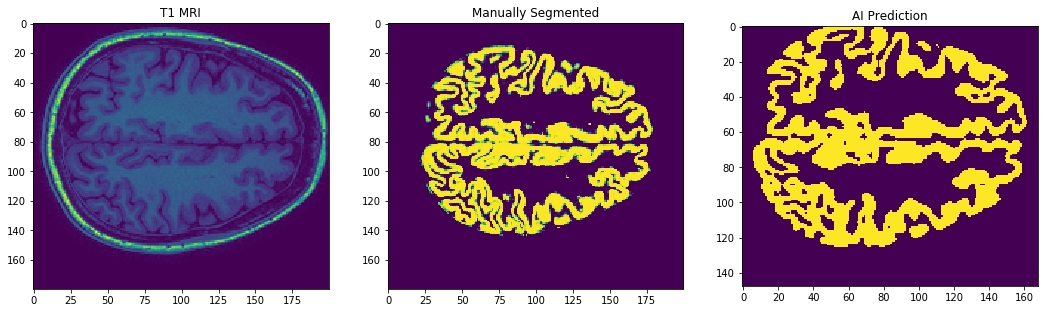

In [58]:
show_images([t1_np, c1_np, done], titles=["T1 MRI", "Manually Segmented", "AI Prediction"])

---
# Helpers

In [0]:
one_index = []
zero_index = []
def label_patches(patches):
    '''
    Always pass in square patches with an odd width and height
    This is needed for use to calculate the center pixel

    :param patches: Patches you would like to label
    :return:
    '''
    labels_list = []
    dim = math.ceil(len(patches[0, 1, :]) / 2)

    for index, patch in enumerate(patches):
        if patch[dim, dim] > 0.95:
            labels_list.append("1")
            one_index.append(index)
        else:
            labels_list.append("0")
            zero_index.append(index)
          
    return keras.utils.to_categorical(labels_list, num_classes=2)

In [0]:
def count_ones(y_array):
  ones_here = []
  for i in y_array:
    if i[1] == 1:
      ones_here.append("1")
  print("We have " + str(len(ones_here)) +"ones out of " +str(len(y_array)))

In [0]:
def show_images(images, cols=1, titles=None):
    """
    Display a list of images in a single figure with matplotlib.
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    cols (Default = 1): Number of columns in figure (number of rows is set to np.ceil(n_images/float(cols))).
    titles: List of titles corresponding to each image. Must have the same length as titles.
    """
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [0]:
print(len(zero_index))
print(len(one_index))

In [0]:
print(zero_index)